In [1]:
import re
from abc import *
from typing import *
import numpy as np
import scipy as sp
import networkx as nx
import mne
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils import shuffle
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.estimation import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.processing.features import prepare_features
from nodestimation.project import  find_subject_dir
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.modification import append_series, promote
import nodestimation.learning.modification as lmd
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib as mpl
from nodestimation.learning.selection import SubjectsStatistic
from scipy.stats import wilcoxon
from sklearn.ensemble import VotingClassifier

In [56]:
nodes = read['nodes']('/home/user/Documents/K1V1_node_estimation_pipeline_file_nodes_creation_output_nodes.pkl')

print(nodes[0].features['0.5-4Hz']['wpli'])

{'eigen': 0.09461535398566705, 'close': 2.3917736531327534, 'between': 0.00027208416470161435}


In [77]:
def prepare_data_test(nodes, centrality_metrics):
    columns = list()
    keys = list()
    datasets = dict()

    for freq_band in nodes[0].features:
        for method in nodes[0].features[freq_band]:
            if freq_band != 'time-domain':
                columns.append(freq_band + '_' + method)
            else:
                columns.append(method)

    columns.append('resected')

    for node in nodes:
        keys.append(node.label.name)

    for centrality in centrality_metrics:
        values = list()
        for node in nodes:
            row = list()
            for freq_band in node.features:
                for method in node.features[freq_band]:
                    row.append(
                        node.features[freq_band][method][centrality]
                    )
            row.append(node.type == 'resected')
            values.append(row)

        data = dict(zip(keys, values))

        datasets.update({centrality: pd.DataFrame.from_dict(data, orient='index', columns=columns)})
        print(centrality, values)

    return datasets

dataset = prepare_data_test(nodes, ['eigen', 'close', 'between'])
print(dataset)

eigen [[0.09461535398566705, 29.64513523431261, 0.08108066154252472, 24.18970097292663, 0.07570376889017633, 35.804073906764586, 0.08093299049073868, 19.143874630110354, 0.08210462364233034, 26.42157986471832, 0.08431818986840889, False], [0.09940063837079581, 30.200418435541664, 0.08747385022365832, 22.851103579457202, 0.07407858589676411, 34.43540441237939, 0.0764830374688589, 20.315708500608814, 0.08022648851858008, 26.113946639764933, 0.08484205269530955, False], [0.07568026930952139, 31.40577430513768, 0.07131712697605355, 24.949611325376708, 0.06605873204295755, 36.3972867391481, 0.0810339433165226, 28.418178713616403, 0.08653914038904748, 36.83721235189498, 0.09703788224463136, False], [0.0708656365724837, 25.152134215749765, 0.07871860564739804, 20.002332521698715, 0.0853065903475569, 29.455575394860467, 0.08508162305252018, 21.923995454341338, 0.07989648002172417, 28.215657786962993, 0.08695475624446616, False], [0.06525305400389729, 23.64893352044527, 0.07139124540259374, 21.

In [3]:
subjects = pipeline(
    methods=['wpli', 'psd', 'envelope'],
    freq_bands=[(0.5, 4), (4, 7), (7, 14), (14, 30), (30, 70)],
    centrality_metrics=['eigen', 'close', 'between']
)

All computation has been already done, loading of the existing file with the solution...


In [32]:
#     s2 = subject.dataset['4-7Hz_imcoh']
#     print(s1.corr(s2))

stat1 = SubjectsStatistic(subjects, 'resected', centrality_metric='eigen')
stat2 = SubjectsStatistic(subjects, 'resected', centrality_metric='close')
stat3 = SubjectsStatistic(subjects, 'resected', centrality_metric='between')

In [52]:
print(subjects[0].dataset)

{'eigen':                           0.5-4Hz_wpli  0.5-4Hz_psd  4-7Hz_wpli  4-7Hz_psd  \
G&S_cingul-Ant-lh             0.076139    28.316203    0.078681  16.656086   
G&S_cingul-Ant-rh             0.083539    25.325905    0.077690  14.316069   
G&S_cingul-Mid-Ant-lh         0.095494    17.506609    0.073324  10.064878   
G&S_cingul-Mid-Ant-rh         0.082593    17.897155    0.072755  10.339721   
G&S_cingul-Mid-Post-lh        0.090825    16.614113    0.073503   9.675347   
...                                ...          ...         ...        ...   
S_temporal_sup-rh             0.074833    22.296580    0.076308  14.493303   
S_temporal_transverse-lh      0.073826    15.003638    0.076786   9.181673   
S_temporal_transverse-rh      0.075721    22.295604    0.089360  13.586324   
Unknown-lh                    0.087043    15.120385    0.079699   8.480501   
Unknown-rh                    0.087402    14.730960    0.082740   8.254084   

                          7-14Hz_wpli  7-14Hz_psd  14

In [180]:
test11 = stat1.test(state='resampled')
test12 = stat1.test(state='reflected')
test21 = stat2.test(state='resampled')
test22 = stat2.test(state='reflected')
test11_samples, test12_samples, test21_samples, test22_samples = list(), list(), list(), list()
for feature in test11.result:
    test11_samples.append(test11.result[feature][1])
    test12_samples.append(test12.result[feature][1])
    test21_samples.append(test21.result[feature][1])
    test22_samples.append(test22.result[feature][1])

test_samples = np.array([
    np.array(test11_samples),
    np.array(test12_samples),
    np.array(test21_samples),
    np.array(test22_samples)
])

df = pd.DataFrame(test_samples, columns=list(test11.result.keys()), index=[
    'resampled', 'reflected', 'resampled, conv', 'reflected, conv'
]).T
print(df)

               resampled  reflected  resampled, conv  reflected, conv
0.5-4Hz_wpli    0.684471   0.639150         0.141429         0.637352
0.5-4Hz_psd     0.519615   0.040919         0.356965         0.317311
0.5-4Hz_imcoh   0.061581   0.113715         0.910325         1.000000
0.5-4Hz_ciplv   0.560957   0.797700         0.217861         0.393769
4-7Hz_wpli      0.004110   0.000453         0.000554         0.004678
4-7Hz_psd       0.856130   0.788061         0.819216         0.317311
4-7Hz_imcoh     0.011342   0.015017         0.193100         0.029049
4-7Hz_ciplv     0.527756   0.955130         0.289934         0.808365
7-14Hz_wpli     0.135127   0.017815         0.010873         0.251349
7-14Hz_psd      0.351583   0.985036         0.296340         0.654721
7-14Hz_imcoh    0.072769   0.063340         0.990021         0.285049
7-14Hz_ciplv    0.074786   0.227585         0.527162         0.393769
14-30Hz_wpli    0.826795   0.398671         0.281782         0.052204
14-30Hz_psd     0.96

/home/user/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [181]:
test11 = stat1.test(state='resampled', test='mannwhitneyu')
test12 = stat1.test(state='reflected', test='mannwhitneyu')
test21 = stat2.test(state='resampled', test='mannwhitneyu')
test22 = stat2.test(state='reflected', test='mannwhitneyu')
test11_samples, test12_samples, test21_samples, test22_samples = list(), list(), list(), list()
for feature in test11.result:
    test11_samples.append(test11.result[feature][1])
    test12_samples.append(test12.result[feature][1])
    test21_samples.append(test21.result[feature][1])
    test22_samples.append(test22.result[feature][1])

test_samples = np.array([
    np.array(test11_samples),
    np.array(test12_samples),
    np.array(test21_samples),
    np.array(test22_samples)
])

df = pd.DataFrame(test_samples, columns=list(test11.result.keys()), index=[
    'resampled', 'reflected', 'resampled, conv', 'reflected, conv'
]).T
print(df)


               resampled  reflected  resampled, conv  reflected, conv
0.5-4Hz_wpli    0.150739   0.255418         0.223656         0.333906
0.5-4Hz_psd     0.044170   0.341987         0.010319         0.410328
0.5-4Hz_imcoh   0.007388   0.142523         0.010838         0.497850
0.5-4Hz_ciplv   0.196456   0.358558         0.223752         0.194207
4-7Hz_wpli      0.003312   0.000650         0.003637         0.004651
4-7Hz_psd       0.179579   0.466136         0.019823         0.411890
4-7Hz_imcoh     0.001956   0.006688         0.001061         0.024152
4-7Hz_ciplv     0.430757   0.306621         0.498185         0.416127
7-14Hz_wpli     0.157104   0.037884         0.126593         0.140134
7-14Hz_psd      0.392482   0.469693         0.352224         0.416127
7-14Hz_imcoh    0.023268   0.080748         0.063555         0.193126
7-14Hz_ciplv    0.057170   0.104391         0.063444         0.193126
14-30Hz_wpli    0.483944   0.071777         0.498185         0.062428
14-30Hz_psd     0.44

In [ ]:
# true_data = stat2.datasets['true']
# false_data = stat2.datasets['false']
#
# mpl.rcParams['text.color'] = 'white'
# mpl.rcParams['xtick.color'] = 'white'
# mpl.rcParams['ytick.color'] = 'white'
# mpl.rcParams['axes.labelcolor'] = 'white'
#
# for i in range(len(true_data.columns)):
#     f, ax = plt.subplots(figsize=(11, 6))
#     sns.violinplot(
#         data=[
#             true_data[true_data.columns[i]].to_numpy(),
#             false_data[false_data.columns[i]].to_numpy(),
#         ],
#         palette="Set3",
#         bw='scott',
#         cut=5,
#         linewidth=2,
#     )
#     labels = ['true', 'false']
#     ax.set_xticks(np.arange(len(labels)))
#     ax.set_xticklabels(labels= labels)
#     ax.set_title(true_data.columns[i] + ', All')

In [190]:
# features = ['4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
# features = ['4-7Hz_wpli', 'envelope']
# features = ['4-7Hz_wpli']
features = ['envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
true_data = stat1.datasets['true'][features]
false_data = stat1.datasets['false_res'][features]
true_data = true_data.assign(resected=True)
false_data = false_data.assign(resected=False)
dataset = pd.concat([true_data, false_data], axis=0)
dataset = dataset.sample(frac = 1)
print(dataset)

# 61

                               envelope  resected
L2M1_G_temporal_middle-rh      0.076257      True
21                             0.081776     False
B1C2_G_pariet_inf-Angular-rh   0.083423      True
3                              0.081492     False
L2M1_G_temp_sup-Plan_polar-lh  0.080529      True
...                                 ...       ...
B1C2_G&S_occipital_inf-rh      0.083817      True
K1V1_G_temporal_middle-rh      0.085507      True
K1V1_S_temporal_inf-rh         0.072837      True
L1P1_S_temporal_transverse-rh  0.089564      True
36                             0.081383     False

[84 rows x 2 columns]


In [183]:
true_data = stat1.datasets['true'][features]
false_data = stat1.datasets['false'][features]
false_res_data = stat1.datasets['false_res'][features]
false_rand_data = stat1.random_samples()[features]
means = pd.concat([false_data.mean(), false_res_data.mean(), false_rand_data.mean(), true_data.mean()], axis=1)
stds = pd.concat([false_data.std(), false_res_data.std(), false_rand_data.std(), true_data.std()], axis=1)

means = pd.DataFrame(means.to_numpy(), index=features, columns=['false', 'false_res', 'false_rand', 'true'])
stds = pd.DataFrame(stds.to_numpy(), index=features, columns=['false', 'false_res', 'false_rand', 'true'])

print(means)
print(stds)

               false  false_res  false_rand      true
4-7Hz_wpli  0.080721   0.080657    0.079361  0.085515
envelope    0.081489   0.081473    0.081706  0.082457
               false  false_res  false_rand      true
4-7Hz_wpli  0.011721   0.001884    0.009747  0.010633
envelope    0.004814   0.000507    0.004677  0.006307


In [192]:
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
for i in range(1000):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10, random_state=0)
    # clf = svm.SVC(kernel='linear')
    clf = svm.SVC()
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)

    true_data = stat1.datasets['true'][features]
    # false_data = stat1.random_samples()[features]
    # false_data = stat1.datasets['false_res'][features]
    # true_data = stat1.random_samples()[features]
    false_data = stat1.random_samples()[features]
    # true_data = stat1.datasets['false_mirror'][features]
    true_data = true_data.assign(resected=True)
    false_data = false_data.assign(resected=False)
    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)


    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()



    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)



    dataset = lmd.suppress(dataset, axis=1, optimal='max')
    # dataset = lmd.promote(dataset, axis=1, optimal='min')
    # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='max')
    # dataset = lmd.binarize(dataset, axis=1)


    x = scaler.fit_transform(dataset)
    # x = dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    # df = pd.DataFrame(np.array([np.array(y_test), pred]).T, columns=['actually', 'prediction'])
    # print(df)
    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec.append(tn / (tn + fp))
    sens.append(tp / (tp + fn))

    if np.isnan(tp/(tp + fp)):
        pospred.append(0)
    else:
        pospred.append(tp/(tp + fp))

    if np.isnan((tn/(tn + fn))):
        negpred.append(0)
    else:
        negpred.append(tn/(tn + fn))

max_acc = np.max(np.array(acc))
min_acc = np.min(np.array(acc))
moda_acc, cacc = sp.stats.mode(np.array(acc))
acc = sum(acc)/len(acc)
max_spec = np.max(np.array(spec))
min_spec = np.min(np.array(spec))
moda_spec, cspec = sp.stats.mode(np.array(spec))
spec = sum(spec)/len(spec)
max_sens = np.max(np.array(sens))
min_sens = np.min(np.array(sens))
moda_sens, csens = sp.stats.mode(np.array(sens))
sens = sum(sens)/len(sens)
max_pospred = np.max(np.array(pospred))
min_pospred = np.min(np.array(pospred))
moda_pospred, cpospred = sp.stats.mode(np.array(pospred))
pospred = sum(pospred)/len(pospred)
max_negpred = np.max(np.array(negpred))
min_negpred = np.min(np.array(negpred))
moda_negpred, cnegspred = sp.stats.mode(np.array(negpred))
negpred = sum(negpred)/len(negpred)
print('Accuracy: ', acc, min_acc, max_acc, moda_acc, cacc)
print('Specifity', spec, min_spec, max_spec, moda_spec, cspec)
print('Sensitivity: ', sens, min_sens, max_sens, moda_sens, csens)
print('Positive Predictive Value: ', pospred, min_pospred, max_pospred, moda_pospred, cpospred)
print('Negative Predictive Value: ', negpred, min_negpred, max_negpred, moda_negpred, cnegspred)


Accuracy:  0.5238095238095238 0.5238095238095238 0.5238095238095238 [0.52380952] [1]
Specifity 0.8 0.8 0.8 [0.8] [1]
Sensitivity:  0.2727272727272727 0.2727272727272727 0.2727272727272727 [0.27272727] [1]
Positive Predictive Value:  0.6 0.6 0.6 [0.6] [1]
Negative Predictive Value:  0.5 0.5 0.5 [0.5] [1]


In [189]:
# clf = svm.SVC(kernel='linear')#probability=True)
clf = svm.SVC()
true_data = stat1.datasets['true'][features]
false_data = stat1.random_samples()[features]
# false_data = stat1.datasets['false_mirror'][features]
true_data = true_data.assign(resected=True)
false_data = false_data.assign(resected=False)
dataset = pd.concat([true_data, false_data], axis=0)
dataset = dataset.sample(frac = 1)
scaler = StandardScaler()
x = scaler.fit_transform(dataset.drop(['resected'], axis=1))
y = dataset['resected'].to_numpy()
dataset = dataset.drop(['resected'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
# des = clf.decision_function(x_test)
# prob = clf.predict_proba(x_test)
# print(des)
# print(prob)
# print(clf.classes_)
coefs = clf.dual_coef_
# print(pd.Series(coefs, index=features))
print(coefs)

Accuracy:  0.6666666666666666
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -0.46403562 -0.6067478  -1.         -1.         -1.         -1.
  -1.         -1.         -0.32496928 -1.         -1.         -1.
  -1.         -1.         -1.         -0.70437287  1.          1.
   1.          1.          1.          1.          1.          1.
   0.25118065  1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          0.84894492  1.          1.
   1.        ]]


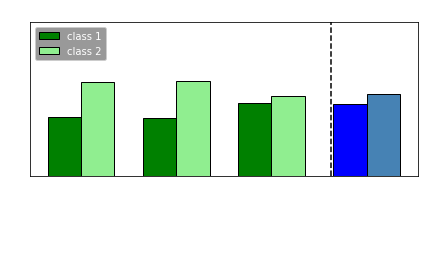

In [138]:
features = ['4-7Hz_wpli', '4-7Hz_psd']
true_data = stat1.datasets['true'][features]
# false_data = stat1.datasets['false_res'][features]
false_data = stat1.random_samples()[features]
true_data = true_data.assign(resected=True)
false_data = false_data.assign(resected=False)
dataset = pd.concat([true_data, false_data], axis=0)
dataset = dataset.sample(frac = 1)


clf1 = LogisticRegression(max_iter=1000, random_state=123)
clf2 = LinearDiscriminantAnalysis()
clf3 = GaussianNB()
clf4 = svm.SVC(probability=True)
X = scaler.fit_transform(dataset.drop(['resected'], axis=1))
y = dataset['resected'].to_numpy()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        voting='soft',
                        weights=[1, 1, 5])

# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf4, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression',
                    'GaussianNB',
                    'SVM',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left', facecolor='grey')
plt.tight_layout()
plt.show()


In [ ]:
# from nodestimation.mlearning.features import prepare_connectivity, prepare_data
# con = pkl.load(open(subjects[0].data['con'], 'rb'))

subjects_dir, subjects_ = find_subject_dir()
labels = mne.read_labels_from_annot('B1C2', parc='aparc', subjects_dir=subjects_dir)
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith('lh')]
rh_labels = [name for name in label_names if name.endswith('rh')]

label_ypos_lh = list()

for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)

try:
    idx = label_names.index('Brain-Stem')

except ValueError:
    pass

else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append('Brain-Stem')
    label_ypos_lh.append(ypos)


lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

rh_labels = [label[:-2] + 'rh' for label in lh_labels
             if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]


node_colors = [label.color for label in labels]

node_order = lh_labels[::-1] + rh_labels

node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) // 2])

In [ ]:
# methods = [
#     'coh',
#     'imcoh',
#     'plv',
#     'ciplv',
#     'ppc',
#     'pli'
# ]
#
# freq_bands = [
#     '0.5-4Hz',
#     '4-7Hz',
#     '7-14Hz',
#     '14-30Hz'
# ]
#
# for method in methods:
#     for freq_band in freq_bands:
#         fig = plt.figure(num=None, figsize=(25, 25), facecolor='black')
#         mne.viz.plot_connectivity_circle(con[freq_band][method]['con'][:, :, 0], label_names, n_lines=300,
#                                          node_angles=node_angles, node_colors=node_colors,
#                                          title='All-to-All Connectivity Epilepsy Condition ({} for {})'
#                                          .format(method, freq_band), padding=8, fontsize_title=35, fontsize_colorbar=25,
#                                          fontsize_names=20, fig=fig
#                                          )

In [ ]:
for subject in subjects:
    fig, ax = plt.subplots(figsize=(15,15))
    display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
    spared = [node.nilearn_coordinates for node in subject.nodes if node.type == 'spared']
    resected = [node.nilearn_coordinates for node in subject.nodes if node.type == 'resected']
    resection = read['resec-mni'](subject.data['resec-mni'])
    display.add_markers(resection, marker_color="violet", marker_size=1)
    display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
    display.add_markers(np.array(resected), marker_color="red", marker_size=250)



